In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

In [2]:
filepath = os.path.join('/home/dude/Desktop/data/email_data', 'full_dataset.csv')

In [3]:
df = pd.read_csv(filepath)

In [4]:
df.dropna(axis=0, inplace=True)
df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27082 entries, 0 to 27081
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   subject  27082 non-null  object 
 1   body     27082 non-null  object 
 2   label    27082 non-null  float64
dtypes: float64(1), object(2)
memory usage: 634.9+ KB


In [6]:
df['label'] = df['label'].astype('int64')

In [7]:
df['label'].value_counts()

label
0    19165
1     7917
Name: count, dtype: int64

In [8]:
total = len(df)
ham_amt = int(df['label'].value_counts().iloc[0])
spam_amt = int(df['label'].value_counts().iloc[1])

percentage_of_spam = round(spam_amt / total, 2)
percentage_of_ham = round(ham_amt / total, 2)

In [9]:
percentage_of_spam

0.29

In [10]:
percentage_of_ham

0.71

In [11]:
from nltk.corpus import stopwords

In [12]:
stop_words = stopwords.words('english')

In [13]:
df['body'] = df['body'].apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in stop_words))

In [14]:
df['subject'] = df['subject'].apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in stop_words))

In [15]:
df.head()

,subject,body,label
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0
1,query : letter frequencies text identification,posting inquiry sergei atamas ( satamas @ umab...,0
2,risk,colleague researching differing degrees risk p...,0
3,request book information,earlier morning phone friend mine living south...,0
4,call abstracts : optimality syntactic theory,content - length : 4437 call papers best good ...,0


In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [17]:
# Combine Subject and Body
df['text'] = df['subject'] + " " + df['body']

X = df['text']
y = df['label']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
vectorizer = TfidfVectorizer()

In [19]:
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [20]:
from sklearn.linear_model import LogisticRegression

In [21]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

In [31]:
from sklearn.metrics import confusion_matrix, classification_report, recall_score, precision_score, accuracy_score, PrecisionRecallDisplay

In [28]:
def all_metrics(true, pred, **kwargs):
    name = kwargs.get('name', None)
    print(f"Metrics for {name}")
    print(f"Recall ---> {round(recall_score(true, pred), 2)}")
    print(f"Precision ---> {round(precision_score(true, pred), 2)}")
    print(f"Accuracy ---> {round(accuracy_score(true, pred), 2)}")

In [23]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3848
           1       0.98      0.92      0.95      1569

    accuracy                           0.97      5417
   macro avg       0.97      0.96      0.97      5417
weighted avg       0.97      0.97      0.97      5417



In [24]:
cf_matrix = confusion_matrix(y_test, y_pred)
cf_matrix

array([[3816,   32],
       [ 118, 1451]])

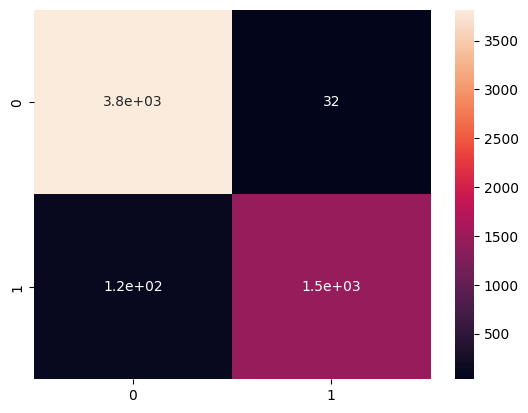

In [25]:
sns.heatmap(cf_matrix, annot=True)
plt.show()

In [30]:
all_metrics(y_test, y_pred, name='Logistic Regression')

Metrics for Logistic Regression
Recall ---> 0.92
Precision ---> 0.98
Accuracy ---> 0.97


In [39]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

In [43]:
lin_svc = LinearSVC(dual='auto')

In [58]:
param_grid = {
    'C':[0.1, 1, 2, 5]
}

In [59]:
grid_search = GridSearchCV(lin_svc, param_grid, n_jobs=10, verbose=1, cv=5)

In [60]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=LinearSVC(dual='auto'), n_jobs=10,
             param_grid={'C': [0.1, 1, 2, 5]}, verbose=1)

In [61]:
grid_search.best_params_

{'C': 1}

In [62]:
best_svm = grid_search.best_estimator_

In [68]:
best_svm.fit(X_train, y_train)

LinearSVC(C=1, dual='auto')

In [69]:
y_pred = best_svm.predict(X_test)

In [70]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3848
           1       0.98      0.96      0.97      1569

    accuracy                           0.98      5417
   macro avg       0.98      0.98      0.98      5417
weighted avg       0.98      0.98      0.98      5417



In [66]:
all_metrics(y_test, y_pred, name='Linear SVM Classifer')

Metrics for Linear SVM Classifer
Recall ---> 0.96
Precision ---> 0.98
Accuracy ---> 0.98


In [67]:
from joblib import load, dump

In [72]:
dump(best_svm, 'model.joblib')

['model.joblib']

In [73]:
dump(vectorizer, 'vectorizer.joblib')

['vectorizer.joblib']